#Hands-on Activity 5.1 Generating Images with GANs and VAEs

**Hernandez, Eujean Marie T. <br> CPE32S8**

#Procedures and Discussion: Variational Autoencoders and GANs

In [ ]:
# system libraries
import sys
import warnings
import os
import glob
warnings.filterwarnings("ignore")

# image libraries
import cv2 # requires installing opencv (e.g., pip install opencv-python)
from imgaug import augmenters # requires installing imgaug (e.g., pip install imgaug)

# math/numerical libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from sklearn.model_selection import train_test_split

import tensorflow as tf

# deep learning libraries
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop

from keras.layers import *
from keras import backend as K
# from keras.callbacks import EarlyStopping
# from keras.utils import to_categorical
# from keras.metrics import *
# from keras.preprocessing import image, sequence
#

print(tf.__version__)

2.15.0


In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

## Part 1: Autoencoders (AEs)

Answer: What is the typical architecture of a 'vanilla/standard/traditional' autoencoder.

**The typical architecture of a 'vanilla/standard/traditional' autoencoder consists of encoder and decoder. The encoder compress the input data into smaller representaion by gradually reducing the number of neuron in each layer. The decoder reconstruct the original dataset.**

### Data: Acquisition and Pre-processing
We will be using Fashion-MNIST, which can be conveniently accessed with Keras.

X_train shape: (60000, 28, 28), X_test shape: (10000, 28, 28)
y_train shape: (60000,), and y_test shape: (10000,)


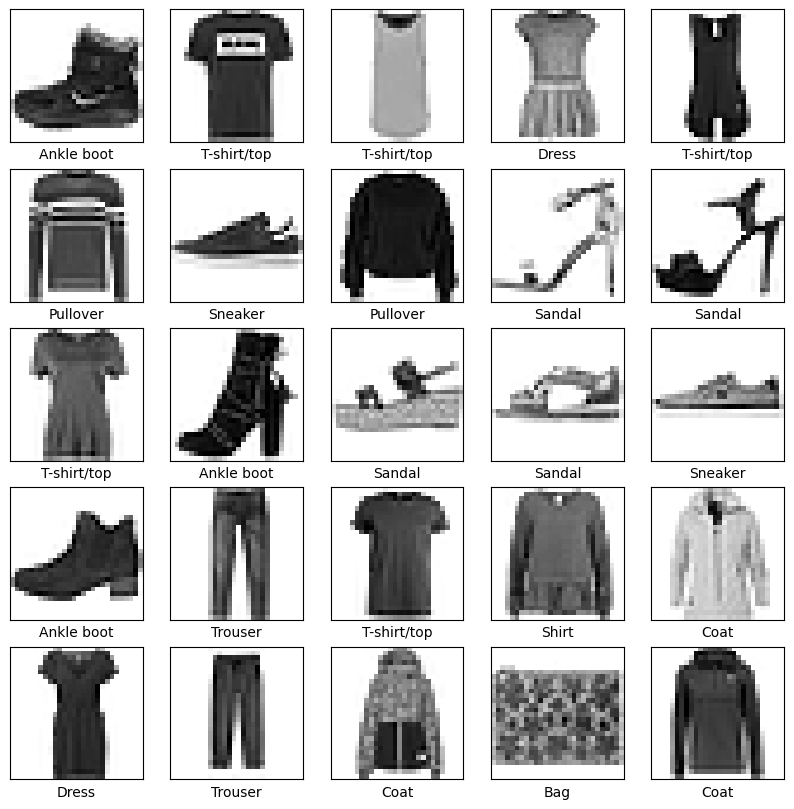

In [ ]:
# get the data from keras - how convenient!
fashion_mnist = tf.keras.datasets.fashion_mnist

# load the data and split it into training and testing sets
(X_train, y_train),(X_test, y_test) = fashion_mnist.load_data()

# normalize the data by dividing with pixel intensity
# (each pixel is 8 bits so its value ranges from 0 to 255)
X_train, X_test = X_train / 255.0, X_test / 255.0

print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}, and y_test shape: {y_test.shape}')

# classes are named 0-9 so define names for plotting clarity
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# display the first 25 garments from the training set
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

#### Add Noise to the Images

In attempt to make the autoencoder more robust and not just memorize the inputs, let's add noise to the inputs but calculate its loss based on how similar its outputs are to the original (non-denoised) images.

Check out imgaug docs for more info and other ways to add noise.

In [ ]:
# Neural Networks want the inputs to be 3D
n_samples, h, w = X_train.shape

X_train = X_train.reshape(-1, h, w, 1)
X_test = X_test.reshape(-1, h, w, 1)

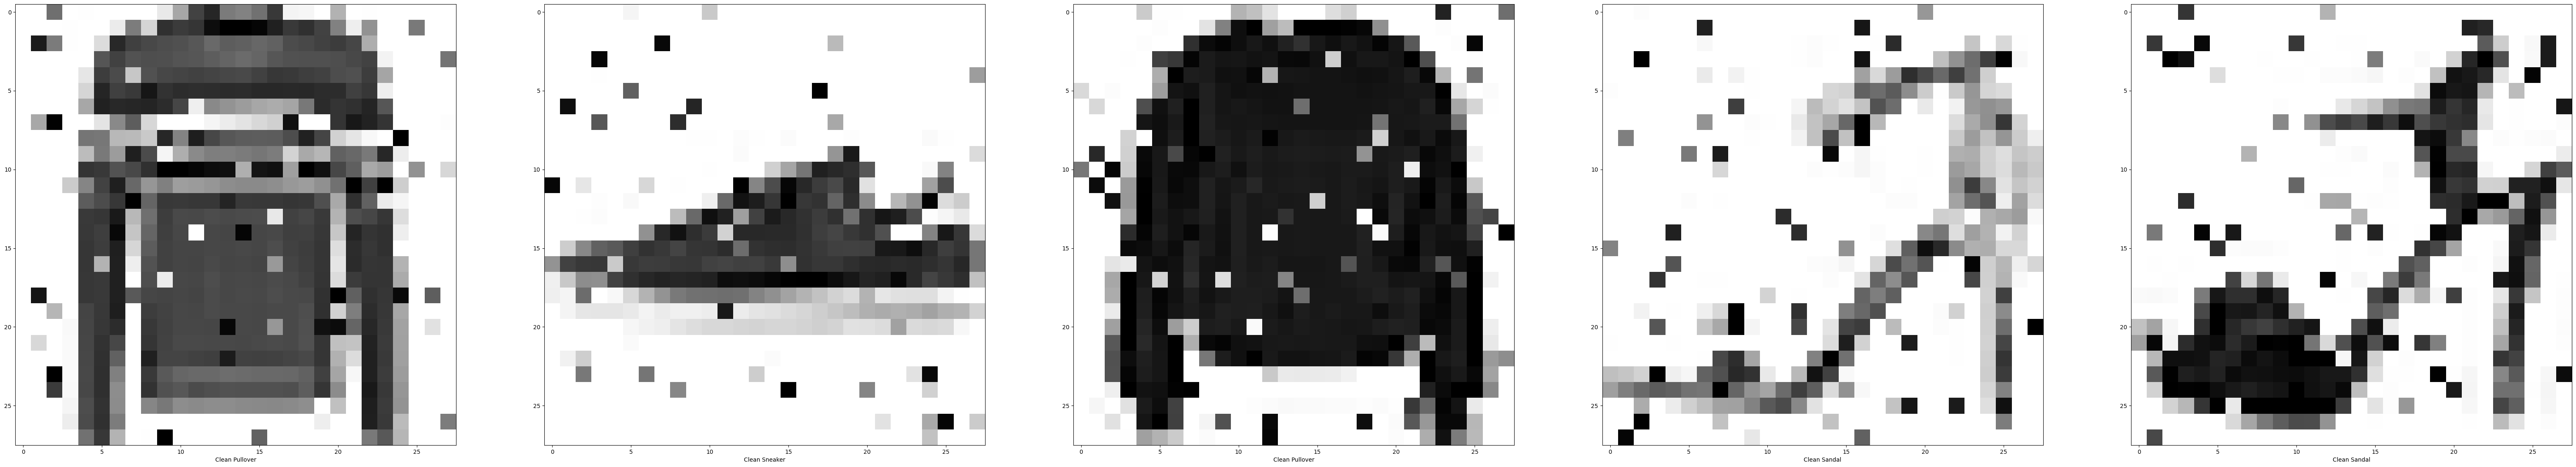

In [ ]:
# Adding some 'salt and pepper' noises
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

X_train_n = seq_object.augment_images(X_train * 255) / 255
X_test_n = seq_object.augment_images(X_test * 255) / 255

f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(X_train_n[i, :, :, 0].reshape(28, 28), cmap=plt.cm.binary)
    ax[i-5].set_xlabel('Clean '+class_names[y_train[i]])

#### Create the Autoencoder

In [ ]:
# input layer
input_layer = tf.keras.layers.Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = tf.keras.layers.Conv2D(64,(3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = tf.keras.layers.MaxPool2D((2, 2), padding='same')(encoded_layer1)
encoded_layer2 = tf.keras.layers.Conv2D(32,(3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = tf.keras.layers.MaxPool2D((2, 2), padding='same')(encoded_layer2)
encoded_layer3 = tf.keras.layers.Conv2D(16,(3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view = tf.keras.layers.MaxPool2D((2, 2), padding='same')(encoded_layer3)

# decoding architecture
decoded_layer1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = tf.keras.layers.UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = tf.keras.layers.UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = tf.keras.layers.UpSampling2D((2, 2))(decoded_layer3)
output_layer = tf.keras.layers.Conv2D(1,(3, 3), padding='same')(decoded_layer3)

# compile the model
model = tf.keras.Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 16)          4624

#### Train the Autoencoder

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')

# epochs=20 for better results
history = model.fit(X_train_n, X_train, epochs=5, batch_size=2048, validation_data=(X_test_n, X_test), callbacks=[early_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 4s 59us/sample - loss: 0.0825 - val_loss: 0.0505
Epoch 2/5
60000/60000 [==============================] - 3s 55us/sample - loss: 0.0427 - val_loss: 0.0356
Epoch 3/5
60000/60000 [==============================] - 3s 55us/sample - loss: 0.0313 - val_loss: 0.0278
Epoch 4/5
60000/60000 [==============================] - 3s 53us/sample - loss: 0.0262 - val_loss: 0.0248
Epoch 5/5
60000/60000 [==============================] - 3s 54us/sample - loss: 0.0239 - val_loss: 0.0228


In [ ]:
n = np.random.randint(0,len(X_test)-5) # pick a random starting index within our test set

#### Visualize Samples reconstructed by AE

**Denoised Images**

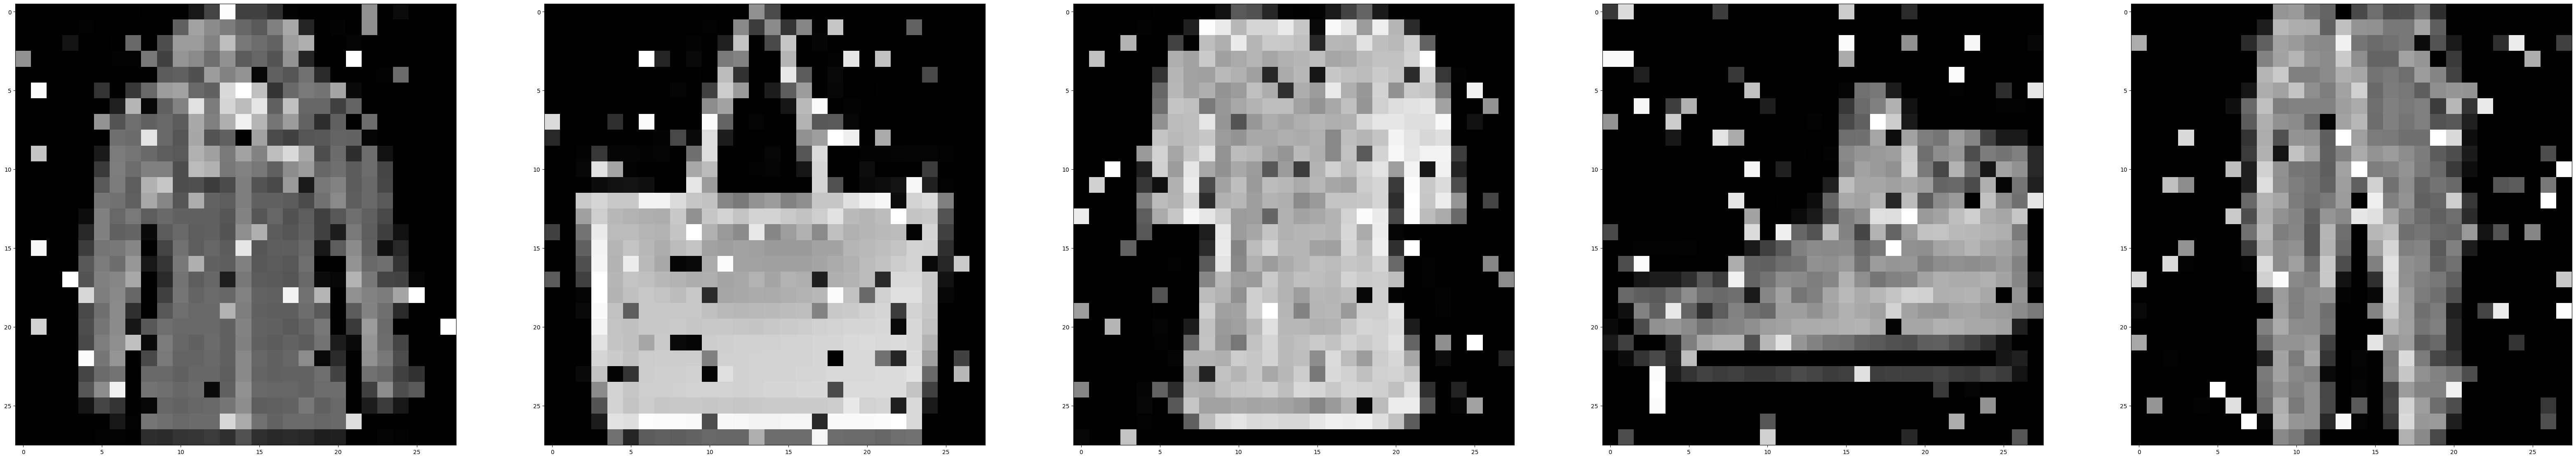

In [ ]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(X_test_n[a, :, :, 0].reshape(28, 28), cmap='gray')

**Actual Targets (i.e., Original inputs)**

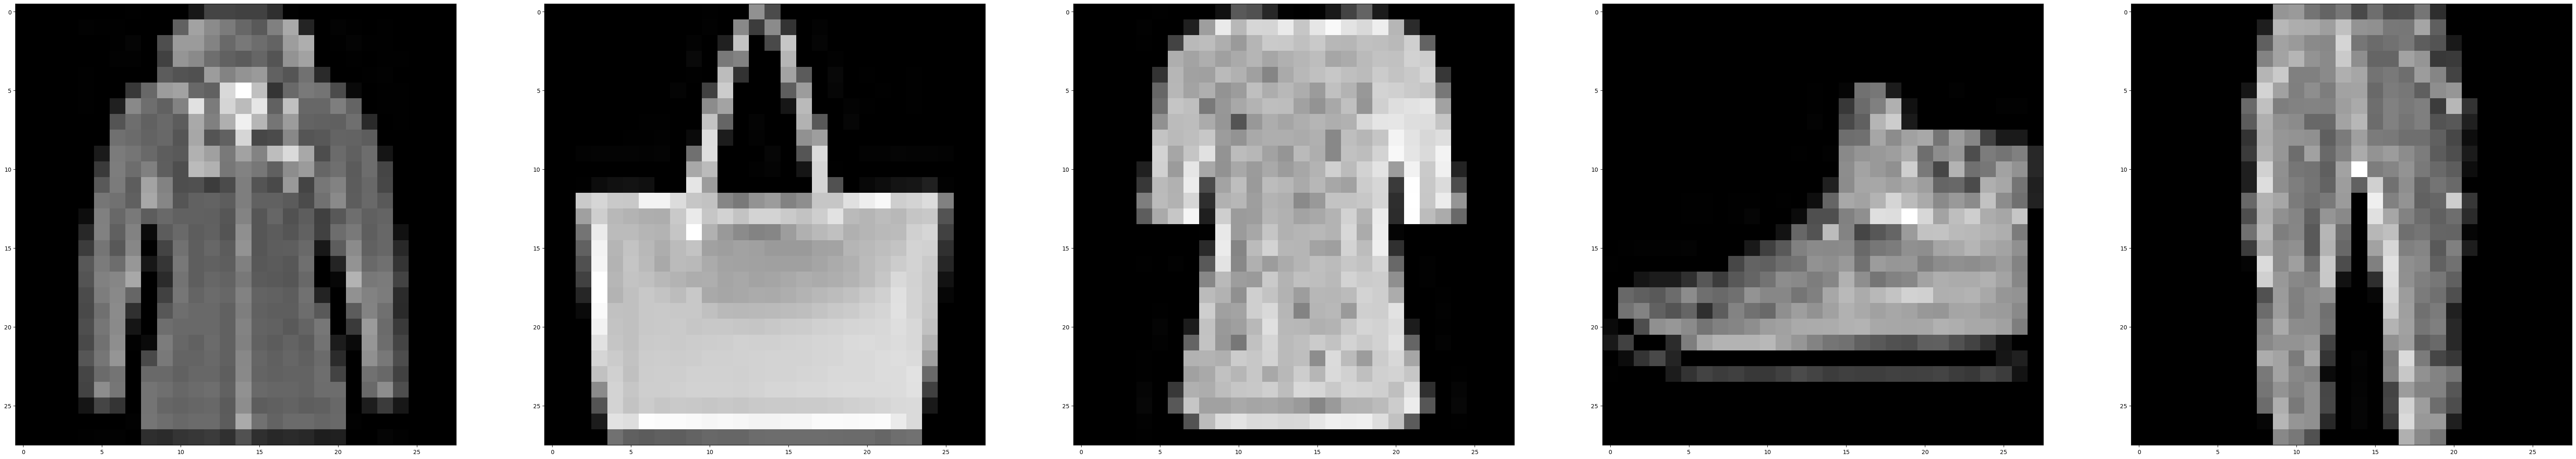

In [ ]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)): # display the 5 images starting at our random index
    ax[i].imshow(X_test[a, :, :, 0].reshape(28, 28), cmap='gray')

**Predicted Images**

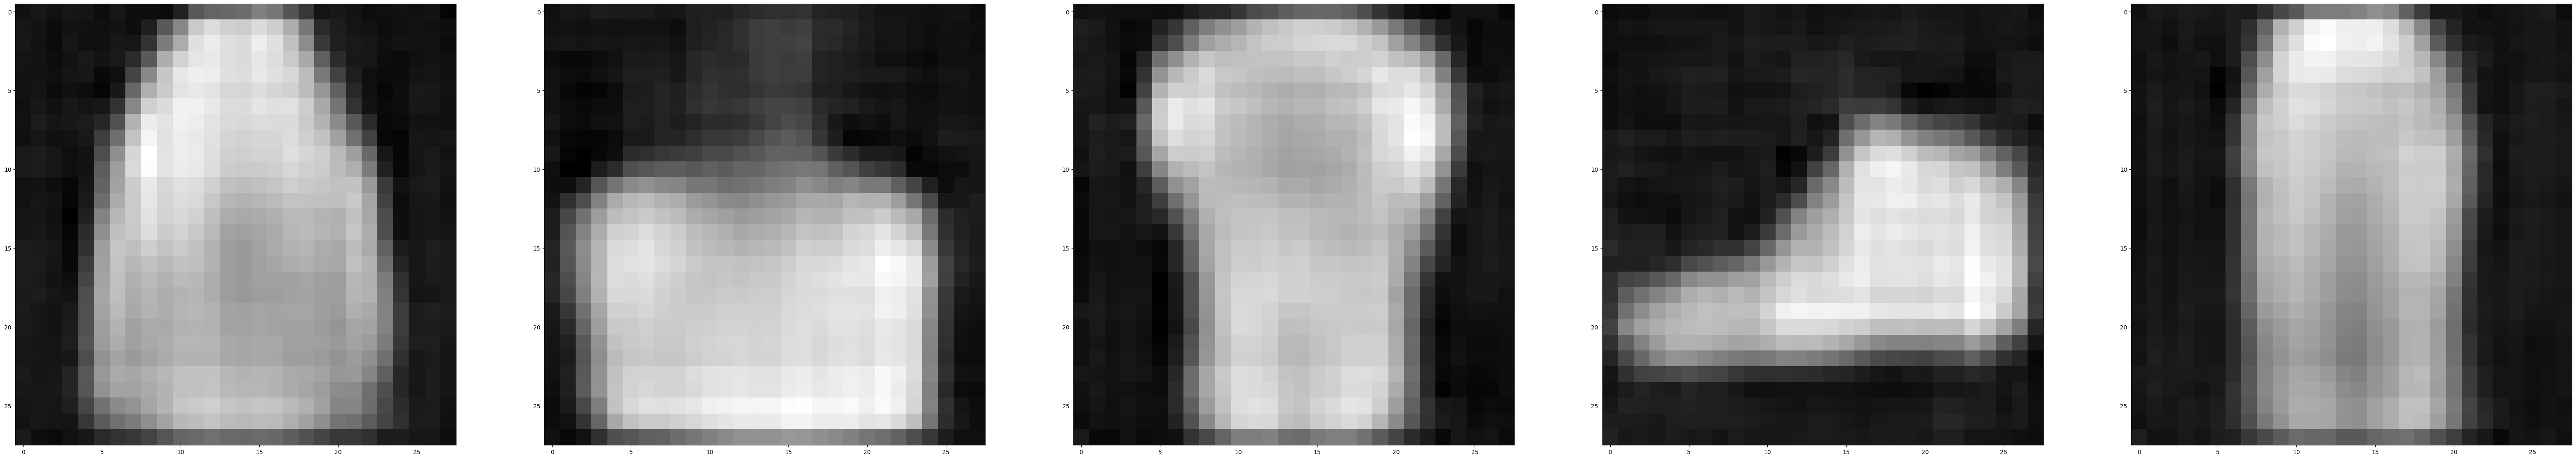

In [ ]:
preds = model.predict(X_test_n[n:n+5])
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(preds[i].reshape(28, 28), cmap='gray')
plt.show()

## Part 2: Variational Autoencoders (VAEs)

**Discussion: Why do we care to use VAEs? Identify the limitations/weaknesses of Autoencoders**

VAEs provide a powerful framework for generating new data samples that resemble the training data. This is particularly useful in tasks such as image generation and text generation. VAE can produce diverse output for a single input. However, the output of VAEs can sometimes be blurry, as they may excessively smooth the image. When performing lossy compression, the decompressed outputs may be degraded compared to the original data.

### Reset Data

In [ ]:
# get the data from keras - how convenient!
fashion_mnist = tf.keras.datasets.fashion_mnist

# load the data and split it into training and testing sets
(X_train, y_train),(X_test, y_test) = fashion_mnist.load_data()

# normalize the data by dividing with pixel intensity
# (each pixel is 8 bits so its value ranges from 0 to 255)
X_train, X_test = X_train / 255.0, X_test / 255.0

print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}, and y_test shape: {y_test.shape}')

X_train shape: (60000, 28, 28), X_test shape: (10000, 28, 28)
y_train shape: (60000,), and y_test shape: (10000,)


### Setup Encoder Neural Network

In [ ]:
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

input_img = tf.keras.layers.Input(shape=(784,), name="input")
x = tf.keras.layers.Dense(512, activation='relu', name="intermediate_encoder")(input_img)
x = tf.keras.layers.Dense(2, activation='relu', name="latent_encoder")(x)

z_mu = tf.keras.layers.Dense(latent_dim)(x)
z_log_sigma = tf.keras.layers.Dense(latent_dim)(x)

In [ ]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mu)[0], latent_dim))
    z = z_mu + tf.keras.backend.exp(z_log_sigma) * epsilon
    return z

# sample vector from the latent distribution
z = tf.keras.layers.Lambda(sampling)([z_mu, z_log_sigma])

In [ ]:
# decoder takes the latent distribution sample as input
decoder_input = tf.keras.layers.Input((2,), name="input_decoder")

x = tf.keras.layers.Dense(512, activation='relu', name="intermediate_decoder", input_shape=(2,))(decoder_input)

# Expand to 784 total pixels
x = tf.keras.layers.Dense(784, activation='sigmoid', name="original_decoder")(x)

# decoder model statement
decoder = tf.keras.Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

In [ ]:
decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_decoder (InputLayer)  [(None, 2)]               0         
                                                                 
 intermediate_decoder (Dens  (None, 512)               1536      
 e)                                                              
                                                                 
 original_decoder (Dense)    (None, 784)               402192    
                                                                 
Total params: 403728 (1.54 MB)
Trainable params: 403728 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(tf.keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = tf.keras.backend.flatten(x)
        z_decoded = tf.keras.backend.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = tf.keras.losses.binary_crossentropy(x, z_decoded)
        return xent_loss

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [ ]:
z_decoded

<tf.Tensor 'model_2/original_decoder/Sigmoid:0' shape=(None, 784) dtype=float32>

In [ ]:
# VAE model statement
vae = tf.keras.Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

In [ ]:
vae.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 784)]                0         []                            
                                                                                                  
 intermediate_encoder (Dens  (None, 512)                  401920    ['input[0][0]']               
 e)                                                                                               
                                                                                                  
 latent_encoder (Dense)      (None, 2)                    1026      ['intermediate_encoder[0][0]']
                                                                                                  
 dense (Dense)               (None, 2)                    6         ['latent_encoder[0][0]']

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
train_x = X_train.reshape(-1,784) # train_x.reshape(-1, 784)
val_x = X_test.reshape(-1,784) #val_x.reshape(-1, 784)

In [ ]:
vae.fit(x=train_x, y=None,
        shuffle=True,
        epochs=4,
        batch_size=batch_size,
        validation_data=(val_x, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 18s 300us/sample - loss: 0.3615 - val_loss: 0.3409
Epoch 2/4
60000/60000 [==============================] - 14s 239us/sample - loss: 0.3375 - val_loss: 0.3354
Epoch 3/4
60000/60000 [==============================] - 13s 220us/sample - loss: 0.3341 - val_loss: 0.3359
Epoch 4/4
60000/60000 [==============================] - 13s 218us/sample - loss: 0.3321 - val_loss: 0.3322


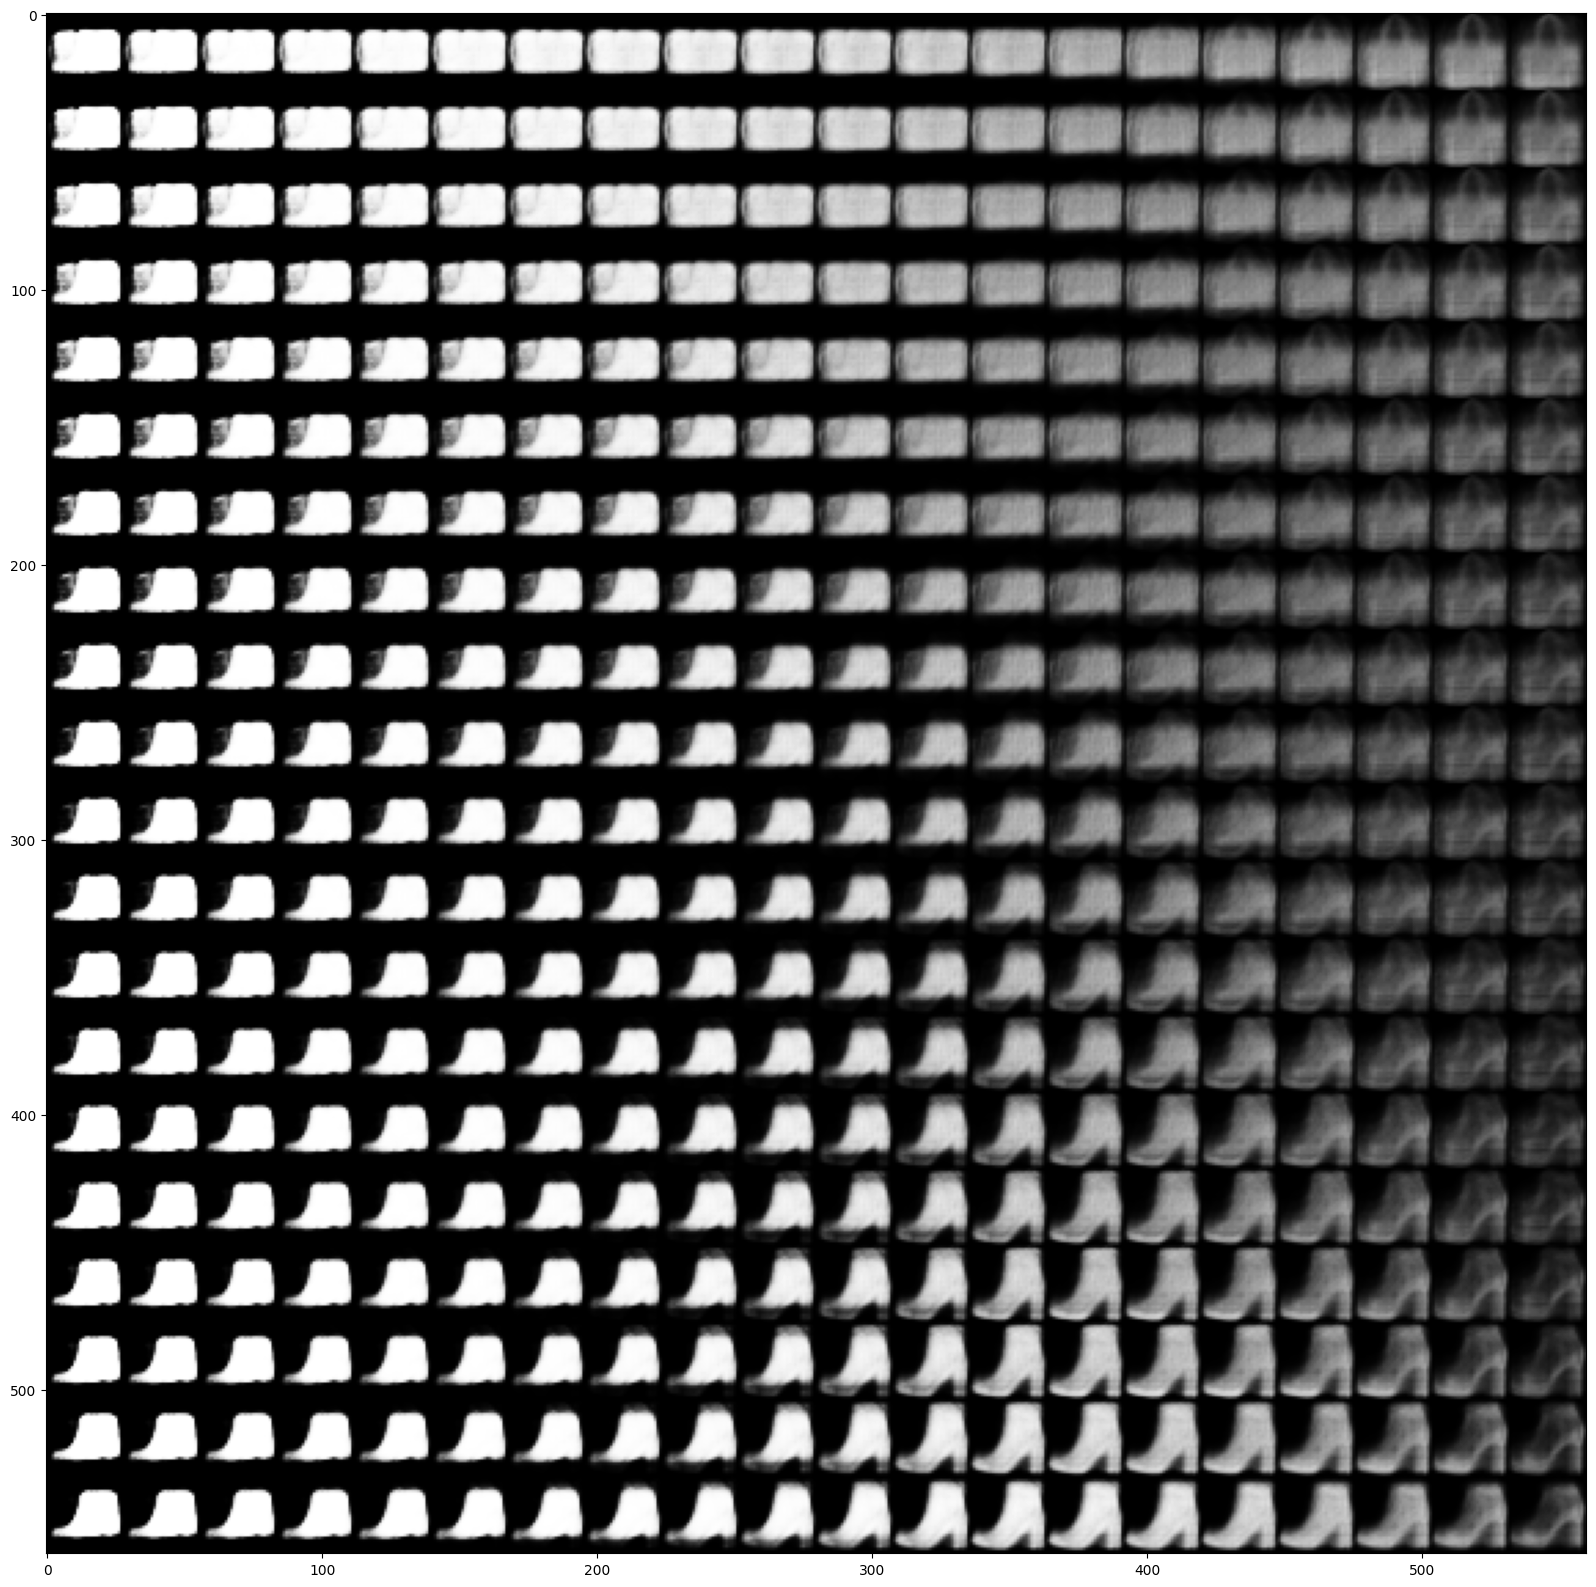

In [ ]:
# Display a 2D manifold of the samples
n = 20  # figure with 20x20 samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values - can change values here to generate different things
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)

        x_decoded = decoder.predict(z_sample, batch_size=batch_size)

        digit = x_decoded[0].reshape(digit_size, digit_size)

        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='gray')
plt.show()

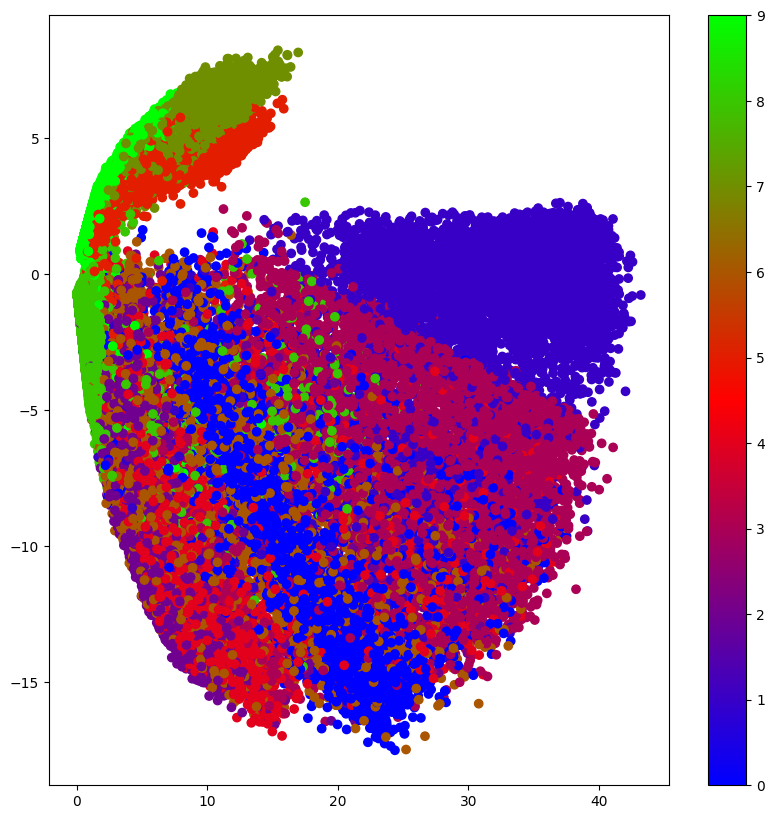

In [ ]:
# Translate into the latent space
encoder = tf.keras.Model(input_img, z_mu) # works on older version of TF and Keras
x_valid_noTest_encoded = encoder.predict(train_x, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=y_train, cmap='brg')
plt.colorbar()
plt.show()

## Part 2B: Adding CNNs and KL Divergence Losses

### Generating new fashion

In [ ]:
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32,3,padding='same', activation='relu')(input_img)
x = Conv2D(64,3,padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64,3,padding='same', activation='relu')(x)
x = Conv2D(64,3,padding='same', activation='relu')(x)

# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

### Setup Sampling Function

In [ ]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim), mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = Lambda(sampling)([z_mu, z_log_sigma])

### Setup Decoder Neural Network
Task: Try different number of hidden layers and nodes?

In [ ]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# reshape
x = Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = Conv2DTranspose(32, 3,
                           padding='same',
                           activation='relu',
                           strides=(2, 2))(x)
x = Conv2D(1, 3,
                  padding='same',
                  activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

### Setup Loss Function

In [ ]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)

        # Reconstruction loss
        xent_loss = tf.keras.losses.binary_crossentropy(x, z_decoded)

        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

### Train VAE

In [ ]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

In [ ]:
vae.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_14 (Conv2D)          (None, 28, 28, 32)           320       ['input_3[0][0]']             
                                                                                                  
 conv2d_15 (Conv2D)          (None, 14, 14, 64)           18496     ['conv2d_14[0][0]']           
                                                                                                  
 conv2d_16 (Conv2D)          (None, 14, 14, 64)           36928     ['conv2d_15[0][0]']           
                                                                                            

In [ ]:
train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

In [ ]:
vae.fit(x=train_x, y=None,
        shuffle=True,
        epochs=20,
        batch_size=batch_size,
        validation_data=(val_x, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 26s 434us/sample - loss: 4361453446.0448 - val_loss: 0.3393
Epoch 2/20
60000/60000 [==============================] - 22s 361us/sample - loss: 0.3358 - val_loss: 0.3356
Epoch 3/20
60000/60000 [==============================] - 22s 365us/sample - loss: 0.3309 - val_loss: 0.3309
Epoch 4/20
60000/60000 [==============================] - 22s 371us/sample - loss: 0.3285 - val_loss: 0.3287
Epoch 5/20
60000/60000 [==============================] - 24s 401us/sample - loss: 0.3270 - val_loss: 0.3280
Epoch 6/20
60000/60000 [==============================] - 22s 370us/sample - loss: 0.3257 - val_loss: 0.3281
Epoch 7/20
60000/60000 [==============================] - 22s 371us/sample - loss: 0.3250 - val_loss: 0.3280
Epoch 8/20
60000/60000 [==============================] - 22s 362us/sample - loss: 0.3244 - val_loss: 0.3278
Epoch 9/20
60000/60000 [==============================] - 22s 370us/s

### Visualize Samples Reconstructed by VAE

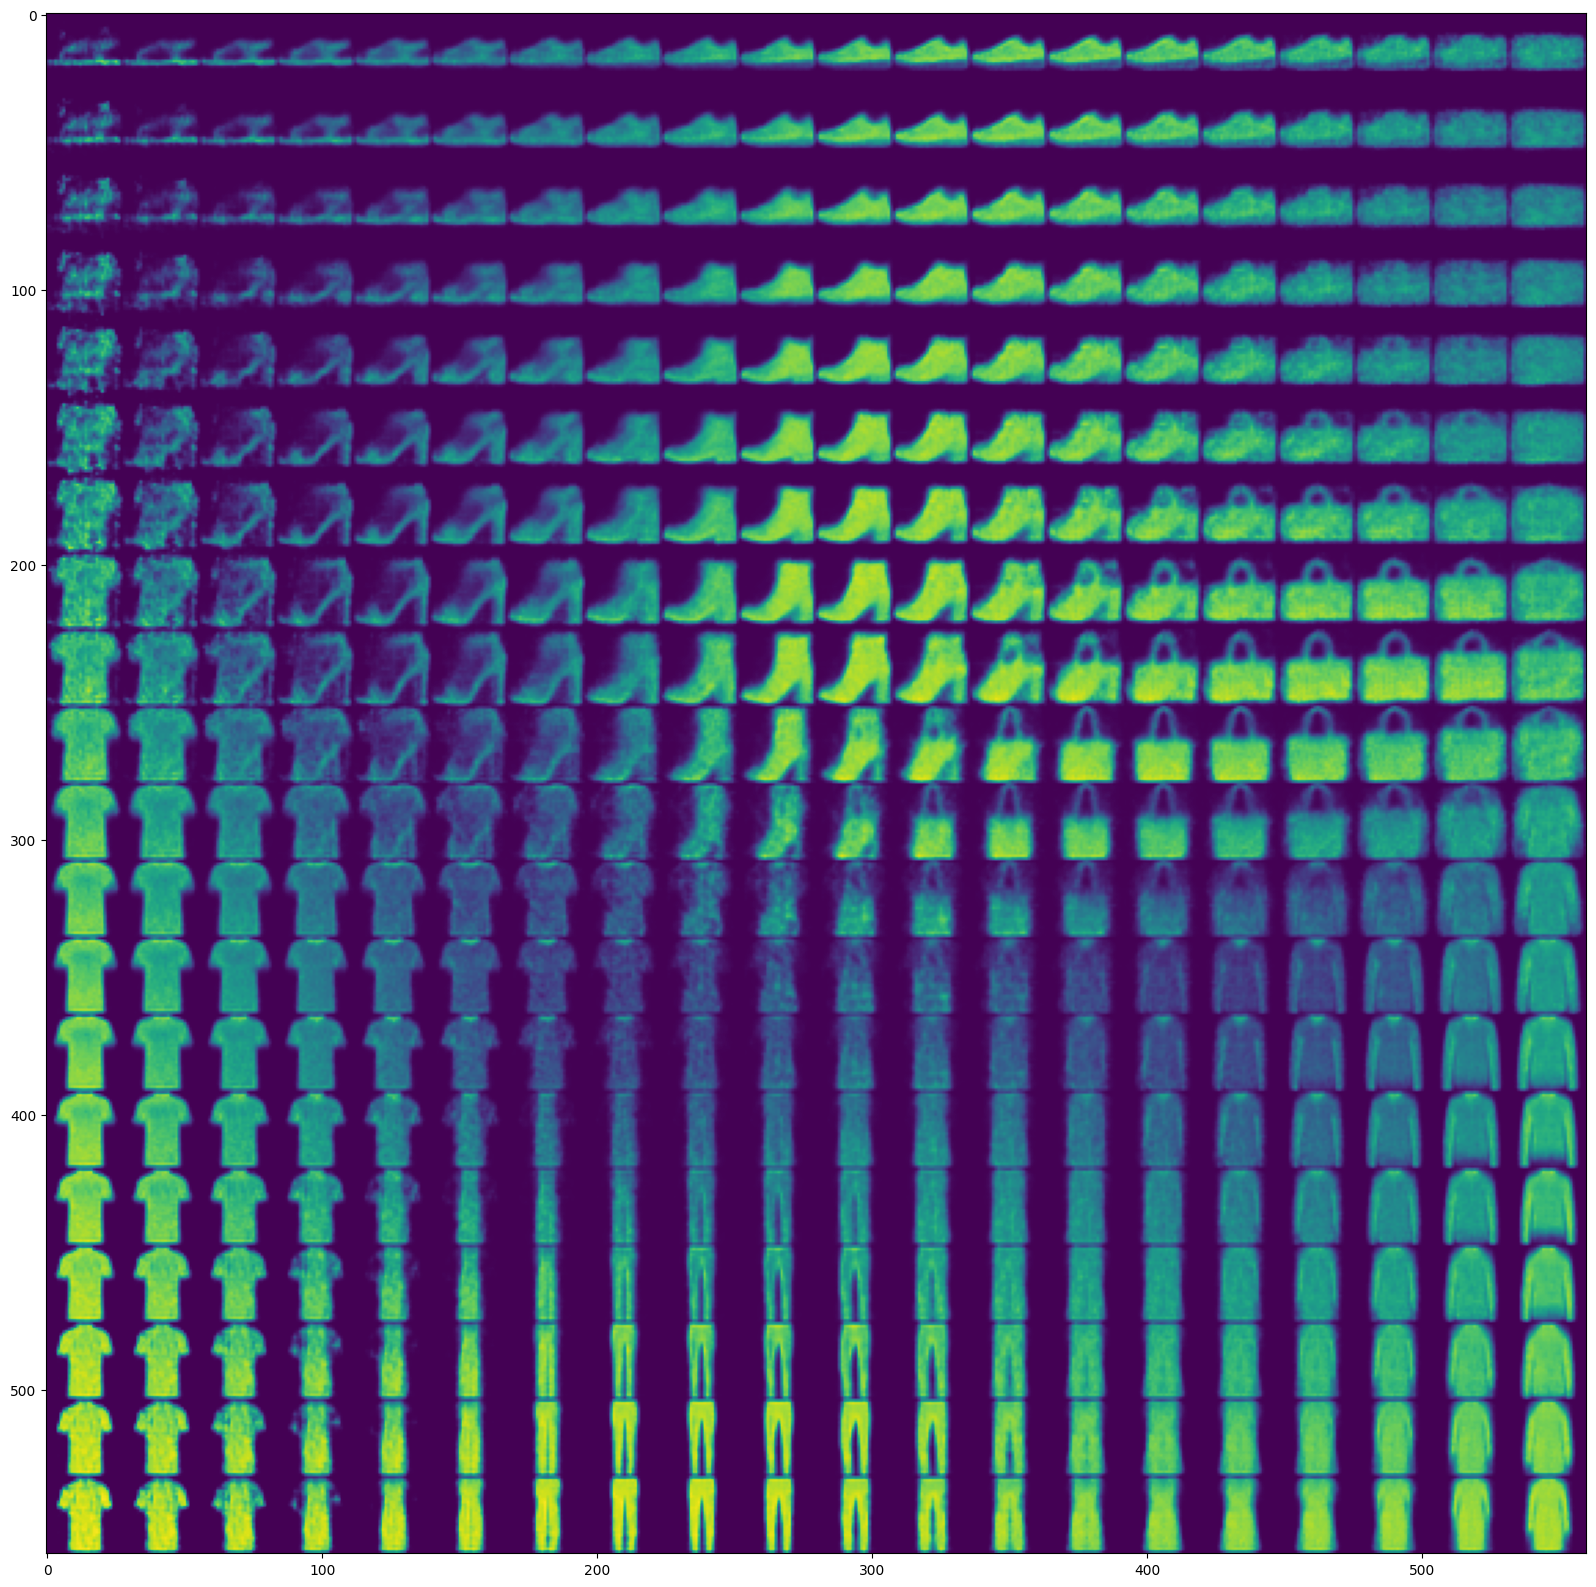

In [ ]:
# Display a 2D manifold of the samples
n = 20  # figure with 20x20 samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values - can change values here to generate different things
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure)
plt.show()

### VAE: Visualize Latent Space

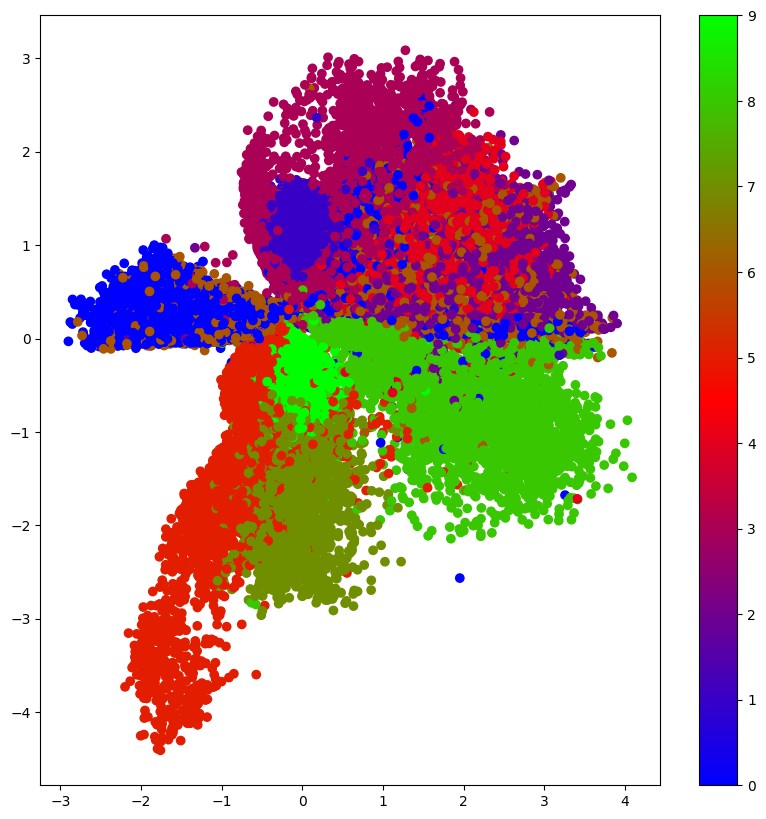

In [ ]:
# Translate into the latent space
encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(train_x, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=y_train, cmap='brg')
plt.colorbar()
plt.show()

## Exercise: Generating a 1D Gaussian Distribution from Uniform Noise

In this exercise, we are going to generate 1-D Gaussian distribution from a n-D uniform distribution. This is a toy exercise in order to understand the ability of GANs (generators) to generate arbitrary distributions from random noise.

Generate training data - Gaussian Distribution

In [ ]:
# system libraries
import sys
import warnings
import os
import glob
warnings.filterwarnings("ignore")

# image libraries
import cv2 # requires installing opencv (e.g., pip install opencv-python)
from imgaug import augmenters # requires installing imgaug (e.g., pip install imgaug)

# math/numerical libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [ ]:
def generate_data(n_samples = 10000,n_dim=1):
  return np.random.randn(n_samples, n_dim)

A general function to define feedforward architectures

In [ ]:
def set_model(input_dim, output_dim, hidden_dim=64,n_layers = 1,activation='tanh',optimizer='adam', loss = 'binary_crossentropy'):
  model = Sequential()
  model.add(Dense(hidden_dim,input_dim=input_dim,activation=activation))

  for _ in range(n_layers-1):
    model.add(Dense(hidden_dim),activation=activation)
  model.add(Dense(output_dim))

  model.compile(loss=loss, optimizer=optimizer)
  print(model.summary())
  return model

Setting GAN training and losses here

In [ ]:
def get_gan_network(discriminator, random_dim, generator, optimizer = 'adam'):
  discriminator.trainable = False
  gan_input = Input(shape=(random_dim,))
  x = generator(gan_input)
  gan_output = discriminator(x)
  gan = Model(inputs = gan_input,outputs=gan_output)
  gan.compile( loss='binary_crossentropy', optimizer=optimizer)
  return gan

In [ ]:
# hyper-parameters
NOISE_DIM = 10
DATA_DIM = 1
G_LAYERS = 1
D_LAYERS = 1

In [ ]:
def train_gan(epochs=1,batch_size=128):
    x_train = generate_data(n_samples=12800,n_dim=DATA_DIM)
    batch_count = x_train.shape[0]/batch_size

    generator = set_model(NOISE_DIM, DATA_DIM, n_layers=G_LAYERS, activation='tanh',loss = 'mean_squared_error')
    discriminator = set_model(DATA_DIM, 1, n_layers= D_LAYERS, activation='sigmoid')
    gan = get_gan_network(discriminator, NOISE_DIM, generator, 'adam')

    for e in range(1,epochs+1):

        # generate noise from a uniform distribution
        noise = np.random.rand(batch_size,NOISE_DIM)
        true_batch = x_train[np.random.choice(x_train.shape[0], batch_size, replace=False), :]

        generated_values = generator.predict(noise)
        X = np.concatenate([generated_values,true_batch])

        y_dis = np.zeros(2*batch_size)

        #One-sided label smoothing to avoid overconfidence. In GAN, if the discriminator depends on a small set of features to detect real images,
        #the generator may just produce these features only to exploit the discriminator.
        #The optimization may turn too greedy and produces no long term benefit.
        #To avoid the problem, we penalize the discriminator when the prediction for any real images go beyond 0.9 (D(real image)>0.9).
        y_dis[:batch_size] = 0.9

        discriminator.trainable = True
        disc_history = discriminator.train_on_batch(X, y_dis)
        discriminator.trainable = False

        # Train generator
        noise = np.random.rand(batch_size,NOISE_DIM)
        y_gen = np.zeros(batch_size)
        gan.train_on_batch(noise, y_gen)

    return generator, discriminator

In [ ]:
generator, discriminator = train_gan()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                704       
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 769 (3.00 KB)
Trainable params: 769 (3.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                128       
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 

1st order moment -  True :  0.0 , GAN : [0.]
2nd order moment -  True :  1.0229097325909349 , GAN : [0.03840209]
3rd order moment -  True :  -0.005692771248618298 , GAN : [-0.00010341]
4th order moment -  True :  3.11210162048125 , GAN : [0.0039116]


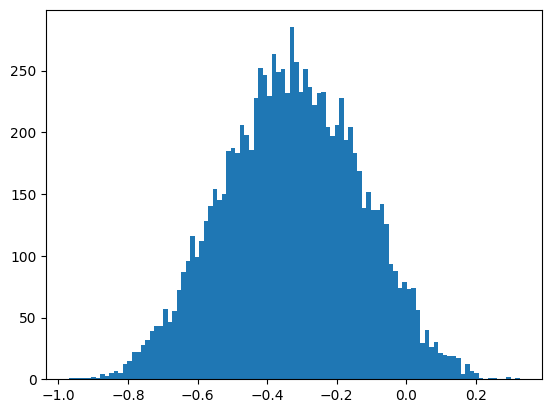

In [ ]:
noise = np.random.rand(10000,NOISE_DIM)
generated_values = generator.predict(noise)
plt.hist(generated_values,bins=100)

true_gaussian = [np.random.randn() for x in range(10000)]

print('1st order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 1) , ', GAN :', scipy.stats.moment(generated_values,1))
print('2nd order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 2) , ', GAN :', scipy.stats.moment(generated_values,2))
print('3rd order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 3) , ', GAN :', scipy.stats.moment(generated_values,3))
print('4th order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 4) , ', GAN :', scipy.stats.moment(generated_values,4))
plt.show()

**CONCLUSION**

Some conclusions we can make from this exercise:
1. GANs are able to learn a generative model from general noise distributions.
2. Traditional GANs do not learn the higher-order moments well. Possible issues : Number of samples, approximating higher moments is hard. Usually known to under-predict higher order variances. For people interested in learning why, read more about divergence measures between distributions (particularly about Wasserstein etc.)


# Supplementary Activities

## Part 1: MNIST GAN - Learn to Generate MNIST Digits

In [1]:
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import LeakyReLU
from keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

# Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()


11490434/11490434 [==============================] - 0s 0us/step


Re-scale data since we are using ReLU activations. **WHY?**

In [2]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

Set noise dimension

**EXERCISE : Play around with different noise dimensions and plot the performance with respect to the size of the noise vector.**

In [3]:
z_dim = 100

Tasks:
1. Build Model using LeakyReLU Activations: Build a generator, discriminator, and a GAN as feed-forward network with multiple layers, dropout, and leakyReLU as activation function.
2. Train Model
3. Provide an evaluation/conclusion.

In [4]:
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import LeakyReLU
from keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [ ]:

z_dim = 100
img_dim = 784

# Generator
generator = Sequential()
generator.add(Dense(256, input_dim=z_dim, activation=LeakyReLU(alpha=0.2)))
generator.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
generator.add(Dense(1024, activation=LeakyReLU(alpha=0.2)))
generator.add(Dense(img_dim, activation='sigmoid'))
generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])


# Discriminator
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=img_dim, activation=LeakyReLU(alpha=0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))  # Values between 0 and 1
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

# GAN
discriminator.trainable = False
z = Input(shape=(z_dim,))
fake_img = generator(z)
validity = discriminator(fake_img)
gan = Model(z, validity)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])


In [5]:

z_dim = 100
img_dim = 784

# Generator
generator = Sequential()
generator.add(Dense(256, input_dim=z_dim, activation=LeakyReLU(alpha=0.2)))
generator.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
generator.add(Dense(1024, activation=LeakyReLU(alpha=0.2)))
generator.add(Dense(img_dim, activation='sigmoid'))
generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])


# Discriminator
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=img_dim, activation=LeakyReLU(alpha=0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))  # Values between 0 and 1
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

# GAN
discriminator.trainable = False
z = Input(shape=(z_dim,))
fake_img = generator(z)
validity = discriminator(fake_img)
gan = Model(z, validity)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])


In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 dense_3 (Dense)             (None, 784)               803600    
                                                                 
Total params: 1486352 (5.67 MB)
Trainable params: 1486352 (5.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [ ]:
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 784)               1486352   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1460225   
                                                                 
Total params: 2946577 (11.24 MB)
Trainable params: 1486352 (5.67 MB)
Non-trainable params: 1460225 (5.57 MB)
_________________________________________________________________


In [6]:
def train_gan(epochs=300, batch_size=128, sample_interval=5):
    for epoch in range(epochs):
        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        # Generate a batch of fake images
        noise = np.random.normal(0, 1, (batch_size, z_dim))
        fake_imgs = generator.predict(noise)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((batch_size, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, z_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Print the progress
        if epoch % sample_interval == 0:
            print(f"Epoch {epoch}, Discriminator Loss: {d_loss[0]}, Discriminator Accuracy: {100*d_loss[1]}%, Generator Loss: {g_loss}")

# Train the GAN
train_gan()

4/4 [==============================] - 1s 13ms/step
Epoch 0, Discriminator Loss: 3.951791301369667, Discriminator Accuracy: 47.265625%, Generator Loss: [0.7207165956497192, 0.484375]
4/4 [==============================] - 0s 9ms/step
Epoch 5, Discriminator Loss: 0.09492042288184166, Discriminator Accuracy: 98.4375%, Generator Loss: [5.288093566894531, 0.0]
4/4 [==============================] - 0s 6ms/step
Epoch 10, Discriminator Loss: 0.033791033551096916, Discriminator Accuracy: 100.0%, Generator Loss: [4.569841384887695, 0.0]
4/4 [==============================] - 0s 6ms/step
Epoch 15, Discriminator Loss: 0.057278398890048265, Discriminator Accuracy: 98.046875%, Generator Loss: [5.996372222900391, 0.0]
4/4 [==============================] - 0s 7ms/step
Epoch 20, Discriminator Loss: 0.0673665376380086, Discriminator Accuracy: 98.828125%, Generator Loss: [10.679524421691895, 0.0]
4/4 [==============================] - 0s 7ms/step
Epoch 25, Discriminator Loss: 1.3798608779947998, Discr

1/1 [==============================] - 0s 236ms/step


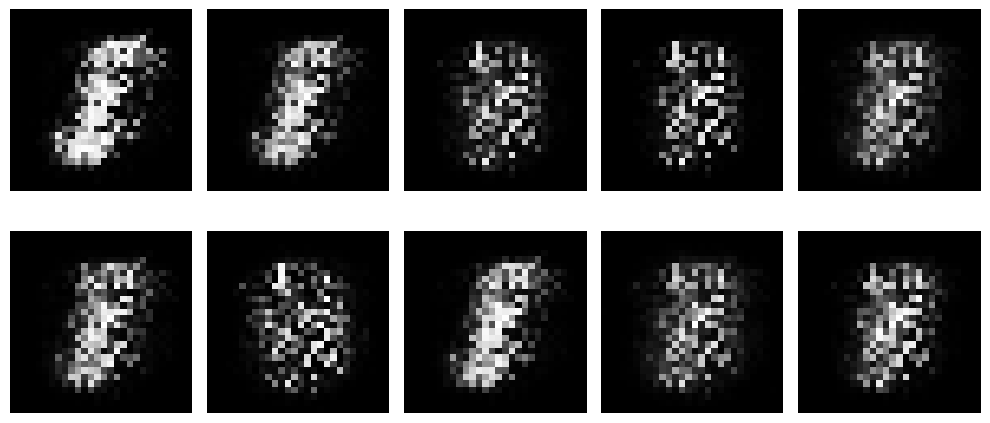

In [7]:
# Generate images

def generate_images(n_images=10):
    noise = np.random.normal(0, 1, (n_images, z_dim))
    generated_images = generator.predict(noise)

    generated_images = generated_images.reshape(n_images, 28, 28)

    plt.figure(figsize=(10, 5))
    for i in range(n_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate and display images
generate_images()


It did not generate a good quality image

## Part 2: GANs and VAEs

Tasks:
1. Use your own dataset.
2. Generate new images using GAN and VAE
3. Compare the results of generating images using GAN and VAE.

# Using EMNIST dataset

In [5]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [122]:
train_df = pd.read_csv('/content/emnist-balanced-train.csv', header=None)
test_df = pd.read_csv('/content/emnist-balanced-test.csv', header=None)
train_df.head()

0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0   45    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1   36    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2   43    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3   15    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    4    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]

In [123]:
X_train = train_df.loc[:, 1:]
y_train = train_df.loc[:, 0]
X_test = test_df.loc[:, 1:]
y_test = test_df.loc[:, 0]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((112800, 784), (112800,), (18800, 784), (18800,))

In [124]:
label_map = pd.read_csv("/content/emnist-balanced-mapping.txt",
                        delimiter = ' ',
                        index_col=0,
                        header=None).squeeze()
label_dictionary = {}
for index, label in enumerate(label_map):
    label_dictionary[index] = chr(label)

label_dictionary

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z',
 36: 'a',
 37: 'b',
 38: 'd',
 39: 'e',
 40: 'f',
 41: 'g',
 42: 'h',
 43: 'n',
 44: 'q',
 45: 'r',
 46: 't'}

In [125]:
sample_image = X_train.iloc[35]
sample_label = y_train.iloc[35]
sample_image.shape, sample_label

((784,), 35)

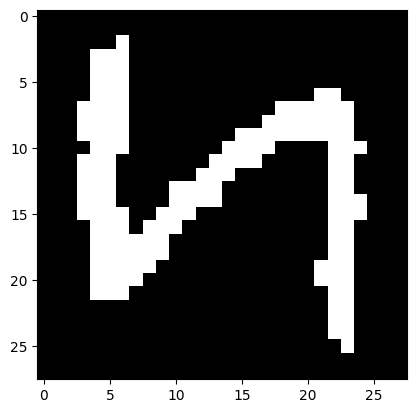

Z


In [126]:
sample_image=sample_image.values.astype(np.uint8).reshape(28,28)
sample_image= cv2.threshold(sample_image, 100, 255, cv2.THRESH_BINARY)[1]
plt.imshow(sample_image, cmap=plt.cm.gray)
plt.show()
print(label_dictionary[sample_label])

In [127]:
def transformations(image):
    W = 28
    H = 28
    image = image.reshape(W, H)
    image = np.fliplr(image)
    image = np.rot90(image)
    image= cv2.threshold(image, 100, 255, cv2.THRESH_BINARY)[1]
    return image

X_train = np.apply_along_axis(transformations, 1, X_train.values.astype(np.uint8))

X_test = np.apply_along_axis(transformations, 1, X_test.values.astype(np.uint8))
X_train.shape

(112800, 28, 28)

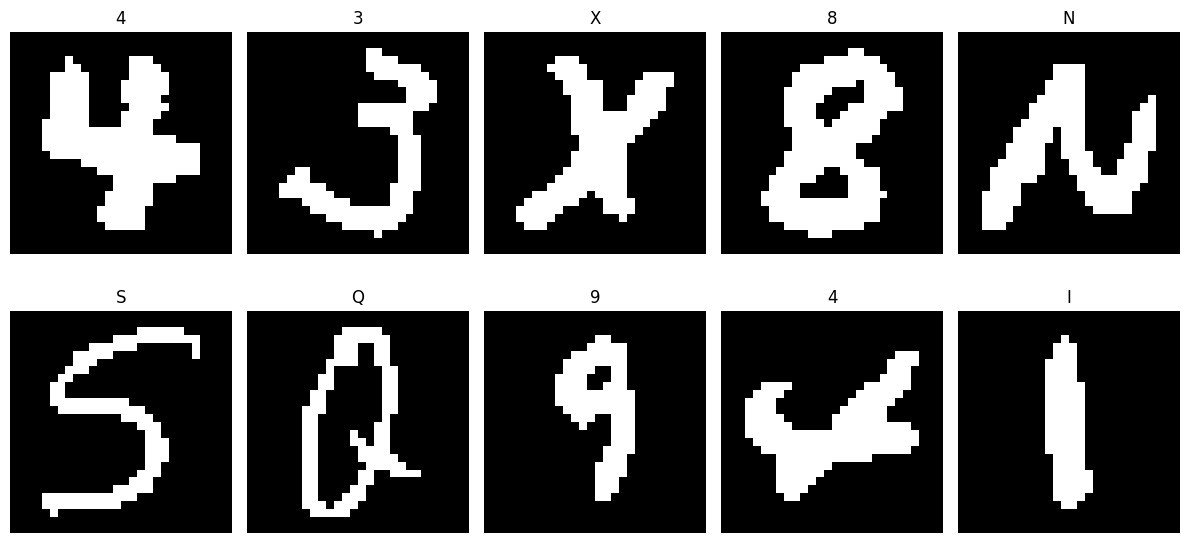

In [128]:
import matplotlib.pyplot as plt

# Function to plot images
def plot_images(images, labels, label_dictionary, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
    axes = axes.flatten()

    for i in range(rows * cols):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title(label_dictionary[labels[i]])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Selecting random samples
random_indices = np.random.choice(len(X_train), size=10, replace=False)
sample_images = X_train[random_indices]
sample_labels = y_train.values[random_indices]

# Plotting the sample images
plot_images(sample_images, sample_labels, label_dictionary)


In [129]:
X_train = X_train.astype('float32') / 255
X_train = X_train.reshape(-1,1,28,28)

X_test = X_test.astype('float32') / 255
X_test = X_test.reshape(-1,1,28,28)

X_train.shape,y_train.shape, X_test.shape,y_test.shape

((112800, 1, 28, 28), (112800,), (18800, 1, 28, 28), (18800,))

In [130]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataloader = DataLoader([[X_train[i], y_train[i]] for i in range(len(y_train))], shuffle=True, batch_size=32)
test_dataloader = DataLoader([[X_test[i], y_test[i]] for i in range(len(y_test))], batch_size=32)

In [131]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(train_features_batch.shape, train_labels_batch.shape)
test_features_batch, test_labels_batch = next(iter(test_dataloader))
print(test_features_batch.shape, test_labels_batch.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])
torch.Size([32, 1, 28, 28]) torch.Size([32])


# GAN

In [132]:
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input

z_dim = 100
img_dim = 784

# Generator
generator = Sequential([
    Dense(256, input_dim=z_dim, activation=LeakyReLU(alpha=0.2)),
    Dense(512, activation=LeakyReLU(alpha=0.2)),
    Dense(1024, activation=LeakyReLU(alpha=0.2)),
    Dense(img_dim, activation='sigmoid'),
    Reshape((28, 28))

])
generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

# Discriminator
discriminator = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(1024, activation=LeakyReLU(alpha=0.2)),
    Dropout(0.3),
    Dense(512, activation=LeakyReLU(alpha=0.2)),
    Dropout(0.3),
    Dense(256, activation=LeakyReLU(alpha=0.2)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

# GAN
discriminator.trainable = False
z = Input(shape=(z_dim,))
fake_img = generator(z)
validity = discriminator(fake_img)
gan = Model(z, validity)

# Compile the GAN
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])


In [32]:
generator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 256)               25856     
                                                                 
 dense_25 (Dense)            (None, 512)               131584    
                                                                 
 dense_26 (Dense)            (None, 1024)              525312    
                                                                 
 dense_27 (Dense)            (None, 784)               803600    
                                                                 
 reshape_3 (Reshape)         (None, 28, 28)            0         
                                                                 
Total params: 1486352 (5.67 MB)
Trainable params: 1486352 (5.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_28 (Dense)            (None, 1024)              803840    
                                                                 
 dropout_9 (Dropout)         (None, 1024)              0         
                                                                 
 dense_29 (Dense)            (None, 512)               524800    
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_30 (Dense)            (None, 256)               131328    
                                                                 
 dropout_11 (Dropout)        (None, 256)              

In [34]:
def train_gan(epochs=300, batch_size=128, sample_interval=5):
    for epoch in range(epochs):

        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]


        real_imgs = np.reshape(real_imgs, (batch_size, 28, 28))


        noise = np.random.normal(0, 1, (batch_size, z_dim))
        fake_imgs = generator.predict(noise)


        d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((batch_size, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, z_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))


        if epoch % sample_interval == 0:
            print(f"Epoch {epoch}, Discriminator Loss: {d_loss[0]}, Discriminator Accuracy: {100*d_loss[1]}%, Generator Loss: {g_loss}")


train_gan()


4/4 [==============================] - 0s 3ms/step
Epoch 0, Discriminator Loss: 3.427138566970825, Discriminator Accuracy: 38.671875%, Generator Loss: [0.6304119229316711, 0.65625]
4/4 [==============================] - 0s 3ms/step
Epoch 5, Discriminator Loss: 0.4915134459733963, Discriminator Accuracy: 78.125%, Generator Loss: [3.2616117000579834, 0.0]
4/4 [==============================] - 0s 3ms/step
Epoch 10, Discriminator Loss: 0.13672232255339622, Discriminator Accuracy: 98.828125%, Generator Loss: [8.336332321166992, 0.0]
4/4 [==============================] - 0s 3ms/step
Epoch 15, Discriminator Loss: 0.567080813634675, Discriminator Accuracy: 53.515625%, Generator Loss: [6.722911834716797, 0.0]
4/4 [==============================] - 0s 3ms/step
Epoch 20, Discriminator Loss: 0.34746206392446766, Discriminator Accuracy: 76.171875%, Generator Loss: [12.890376091003418, 0.0]
4/4 [==============================] - 0s 3ms/step
Epoch 25, Discriminator Loss: 0.17851882614195347, Discri

1/1 [==============================] - 0s 82ms/step


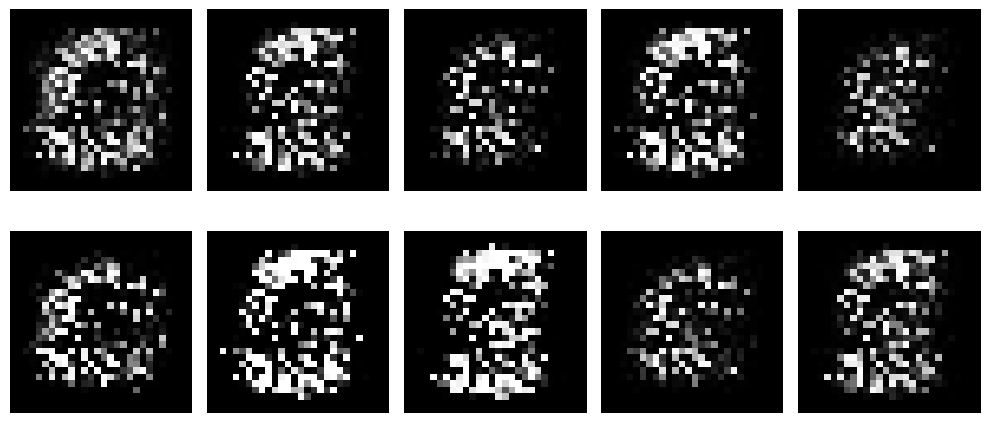

In [134]:
import matplotlib.pyplot as plt

def generate_images(generator, num_images=10, z_dim=100):
    # Generate random noise vectors
    noise = np.random.normal(0, 1, (num_images, z_dim))


    # Generate images using the generator
    generated_images = generator.predict(noise)


    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate new images using the trained generator
generate_images(generator)


# VAE

In [18]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.encoder_conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.encoder_fc_mu = nn.Linear(64*7*7, 20)  # 7*7 is the dimension after two strides of 2
        self.encoder_fc_logvar = nn.Linear(64*7*7, 20)

        # Decoder layers
        self.decoder_fc = nn.Linear(20, 64*7*7)
        self.decoder_conv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_conv2 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

    def encode(self, x):
        x = F.relu(self.encoder_conv1(x))
        x = F.relu(self.encoder_conv2(x))
        x = x.view(-1, 64*7*7)
        mu = self.encoder_fc_mu(x)
        logvar = self.encoder_fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        z = F.relu(self.decoder_fc(z))
        z = z.view(-1, 64, 7, 7)
        z = F.relu(self.decoder_conv1(z))
        z = torch.sigmoid(self.decoder_conv2(z))
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


In [19]:
vae = VAE()

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

optimizer = optim.Adam(vae.parameters(), lr=0.0001)


# Train VAE

In [20]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_dataloader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_dataloader.dataset),
                100. * batch_idx / len(train_dataloader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_dataloader.dataset)))

# Training loop
for epoch in range(1, 11):
    train(epoch)


Train Epoch: 1 [0/112800 (0%)]	Loss: 524.748901
Train Epoch: 1 [3200/112800 (3%)]	Loss: 292.600586
Train Epoch: 1 [6400/112800 (6%)]	Loss: 243.771729
Train Epoch: 1 [9600/112800 (9%)]	Loss: 176.913956
Train Epoch: 1 [12800/112800 (11%)]	Loss: 148.383255
Train Epoch: 1 [16000/112800 (14%)]	Loss: 147.586899
Train Epoch: 1 [19200/112800 (17%)]	Loss: 158.683350
Train Epoch: 1 [22400/112800 (20%)]	Loss: 147.458115
Train Epoch: 1 [25600/112800 (23%)]	Loss: 145.022217
Train Epoch: 1 [28800/112800 (26%)]	Loss: 140.971252
Train Epoch: 1 [32000/112800 (28%)]	Loss: 136.540863
Train Epoch: 1 [35200/112800 (31%)]	Loss: 136.629120
Train Epoch: 1 [38400/112800 (34%)]	Loss: 147.185150
Train Epoch: 1 [41600/112800 (37%)]	Loss: 137.533539
Train Epoch: 1 [44800/112800 (40%)]	Loss: 137.550507
Train Epoch: 1 [48000/112800 (43%)]	Loss: 131.050217
Train Epoch: 1 [51200/112800 (45%)]	Loss: 136.225677
Train Epoch: 1 [54400/112800 (48%)]	Loss: 138.996490
Train Epoch: 1 [57600/112800 (51%)]	Loss: 157.827454
Trai

#VAE Result

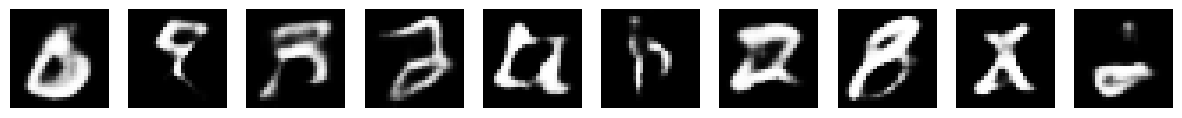

In [28]:
import matplotlib.pyplot as plt

def generate_vae_images(num_images):
    vae.eval()
    with torch.no_grad():

        z = torch.randn(num_images, 20)


        generated_images = vae.decode(z).cpu()
    return generated_images


generated_images_vae = generate_vae_images(10)


fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    axes[i].imshow(generated_images_vae[i].squeeze(), cmap='gray')
    axes[i].axis('off')
plt.show()


# Compare the results of generating images using GAN and VAE.

1/1 [==============================] - 0s 20ms/step


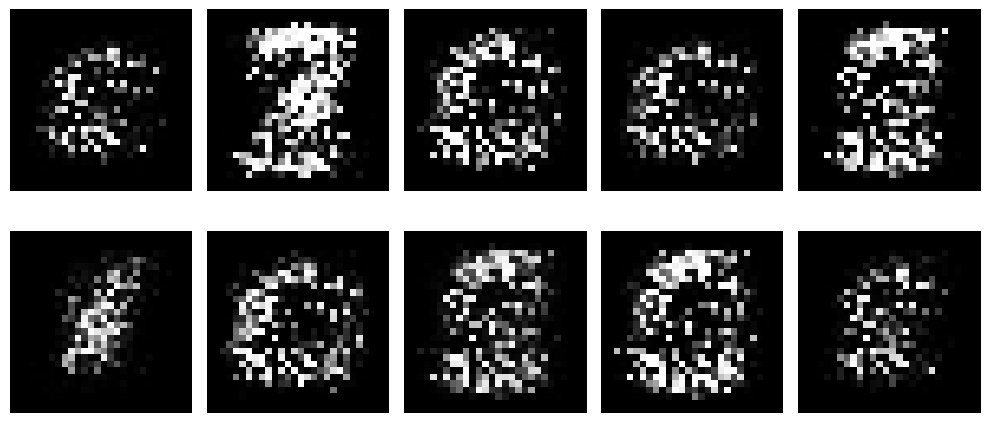

In [136]:
import matplotlib.pyplot as plt

def generate_images(generator, num_images=10, z_dim=100):
    # Generate random noise vectors
    noise = np.random.normal(0, 1, (num_images, z_dim))


    # Generate images using the generator
    generated_images = generator.predict(noise)


    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate new images using the trained generator
generate_images(generator)


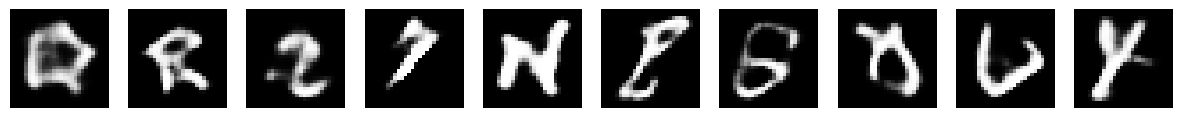

In [171]:
import matplotlib.pyplot as plt

def generate_vae_images(num_images):
    vae.eval()
    with torch.no_grad():

        z = torch.randn(num_images, 20)


        generated_images = vae.decode(z).cpu()
    return generated_images

generated_images_vae = generate_vae_images(10)


fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    axes[i].imshow(generated_images_vae[i].squeeze(), cmap='gray')
    axes[i].axis('off')
plt.show()


As we can see in the output, VAE generates higher-quality images compared to GAN. The VAE images exhibit clearer details and better resemblance to the characters, whereas the GAN images appear blurry and lack sharpness.

# References


> **Variational Autoencoders and GANs**
>
> Harvard University
>
> Fall 2020
>
> Instructors: Mark Glickman, Pavlos Protopapas, and Chris Tanner
>
> Lab Instructors: Chris Tanner and Eleni Angelaki Kaxiras
>
> Content: Srivatsan Srinivasan, Pavlos Protopapas, Chris Tanner
>
> Link: https://harvard-iacs.github.io/2020-CS109B/labs/lab10/notebook/

